In [46]:
import cv2
import numpy as np
from IPython.display import Image

In [9]:
# 关键点检测（DoG）
def detect_keypoints(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    return keypoints, descriptors


In [10]:
# 特征匹配
def match_keypoints(descriptors1, descriptors2):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    
    # 应用比值测试
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
            
    return good_matches

In [140]:
# 图像配准和拼接
def stitch_images(image1, image2):
    # 关键点检测和特征匹配
    keypoints1, descriptors1 = detect_keypoints(image1)
    keypoints2, descriptors2 = detect_keypoints(image2)
    good_matches = match_keypoints(descriptors1, descriptors2)
    
    # 计算单应性矩阵
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    # 图像配准
    h1, w1 = image1.shape[:2]
    h2, w2 = image2.shape[:2]
    warped_image = cv2.warpPerspective(image1, H, (w2 + w1, h2))
    warped_image[:h2, :w2] = image2

    # 平滑过渡以减少缝隙
    blend_width = 5  # 增加平滑过渡的宽度

    for i in range(blend_width):
        # 计算接缝处的列索引
        col_idx = w2 + i-3
        # 计算接缝处的均值
        mean1 = np.mean(image2[:, w2-blend_width:w2], axis=1)
        mean2 = np.mean(warped_image[:, w2:w2+blend_width], axis=1)
        # 更新接缝处的像素值
        warped_image[:, col_idx] = 0.5 * (mean1 + mean2)

    # 去除黑边
    gray_warped = cv2.cvtColor(warped_image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray_warped, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    x, y, w, h = cv2.boundingRect(contours[0])
    stitched_image = warped_image[y:y+h, x:x+w]
    
    return stitched_image

In [141]:

# 加载图像
image1 = cv2.imread('shanghai2.jpg')
image2 = cv2.imread('shanghai1.jpg')
    
 # 图像拼接
stitched_image = stitch_images(image1, image2)
    
cv2.imwrite('stitched_image.jpg', stitched_image)



True

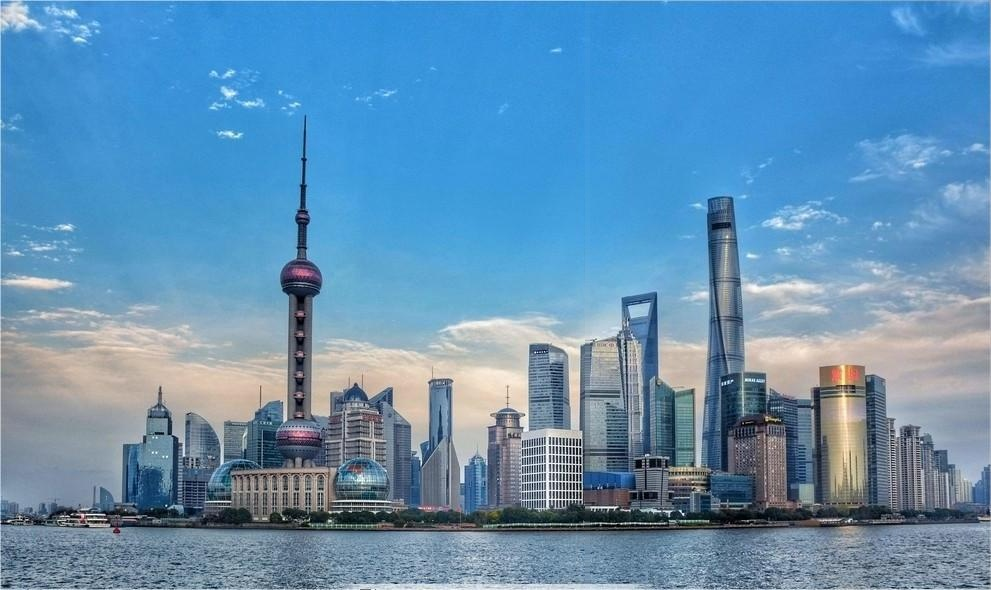

In [142]:
# 加载图像
image_path = 'stitched_image.jpg'

# 显示图像
Image(filename=image_path)

In [138]:
# 加载图像
image1 = cv2.imread('image2_1.jpg')
image2 = cv2.imread('image1_1.jpg')
    
 # 图像拼接
stitched_image = stitch_images(image1, image2)
    
cv2.imwrite('stitched_image2.jpg', stitched_image)

True

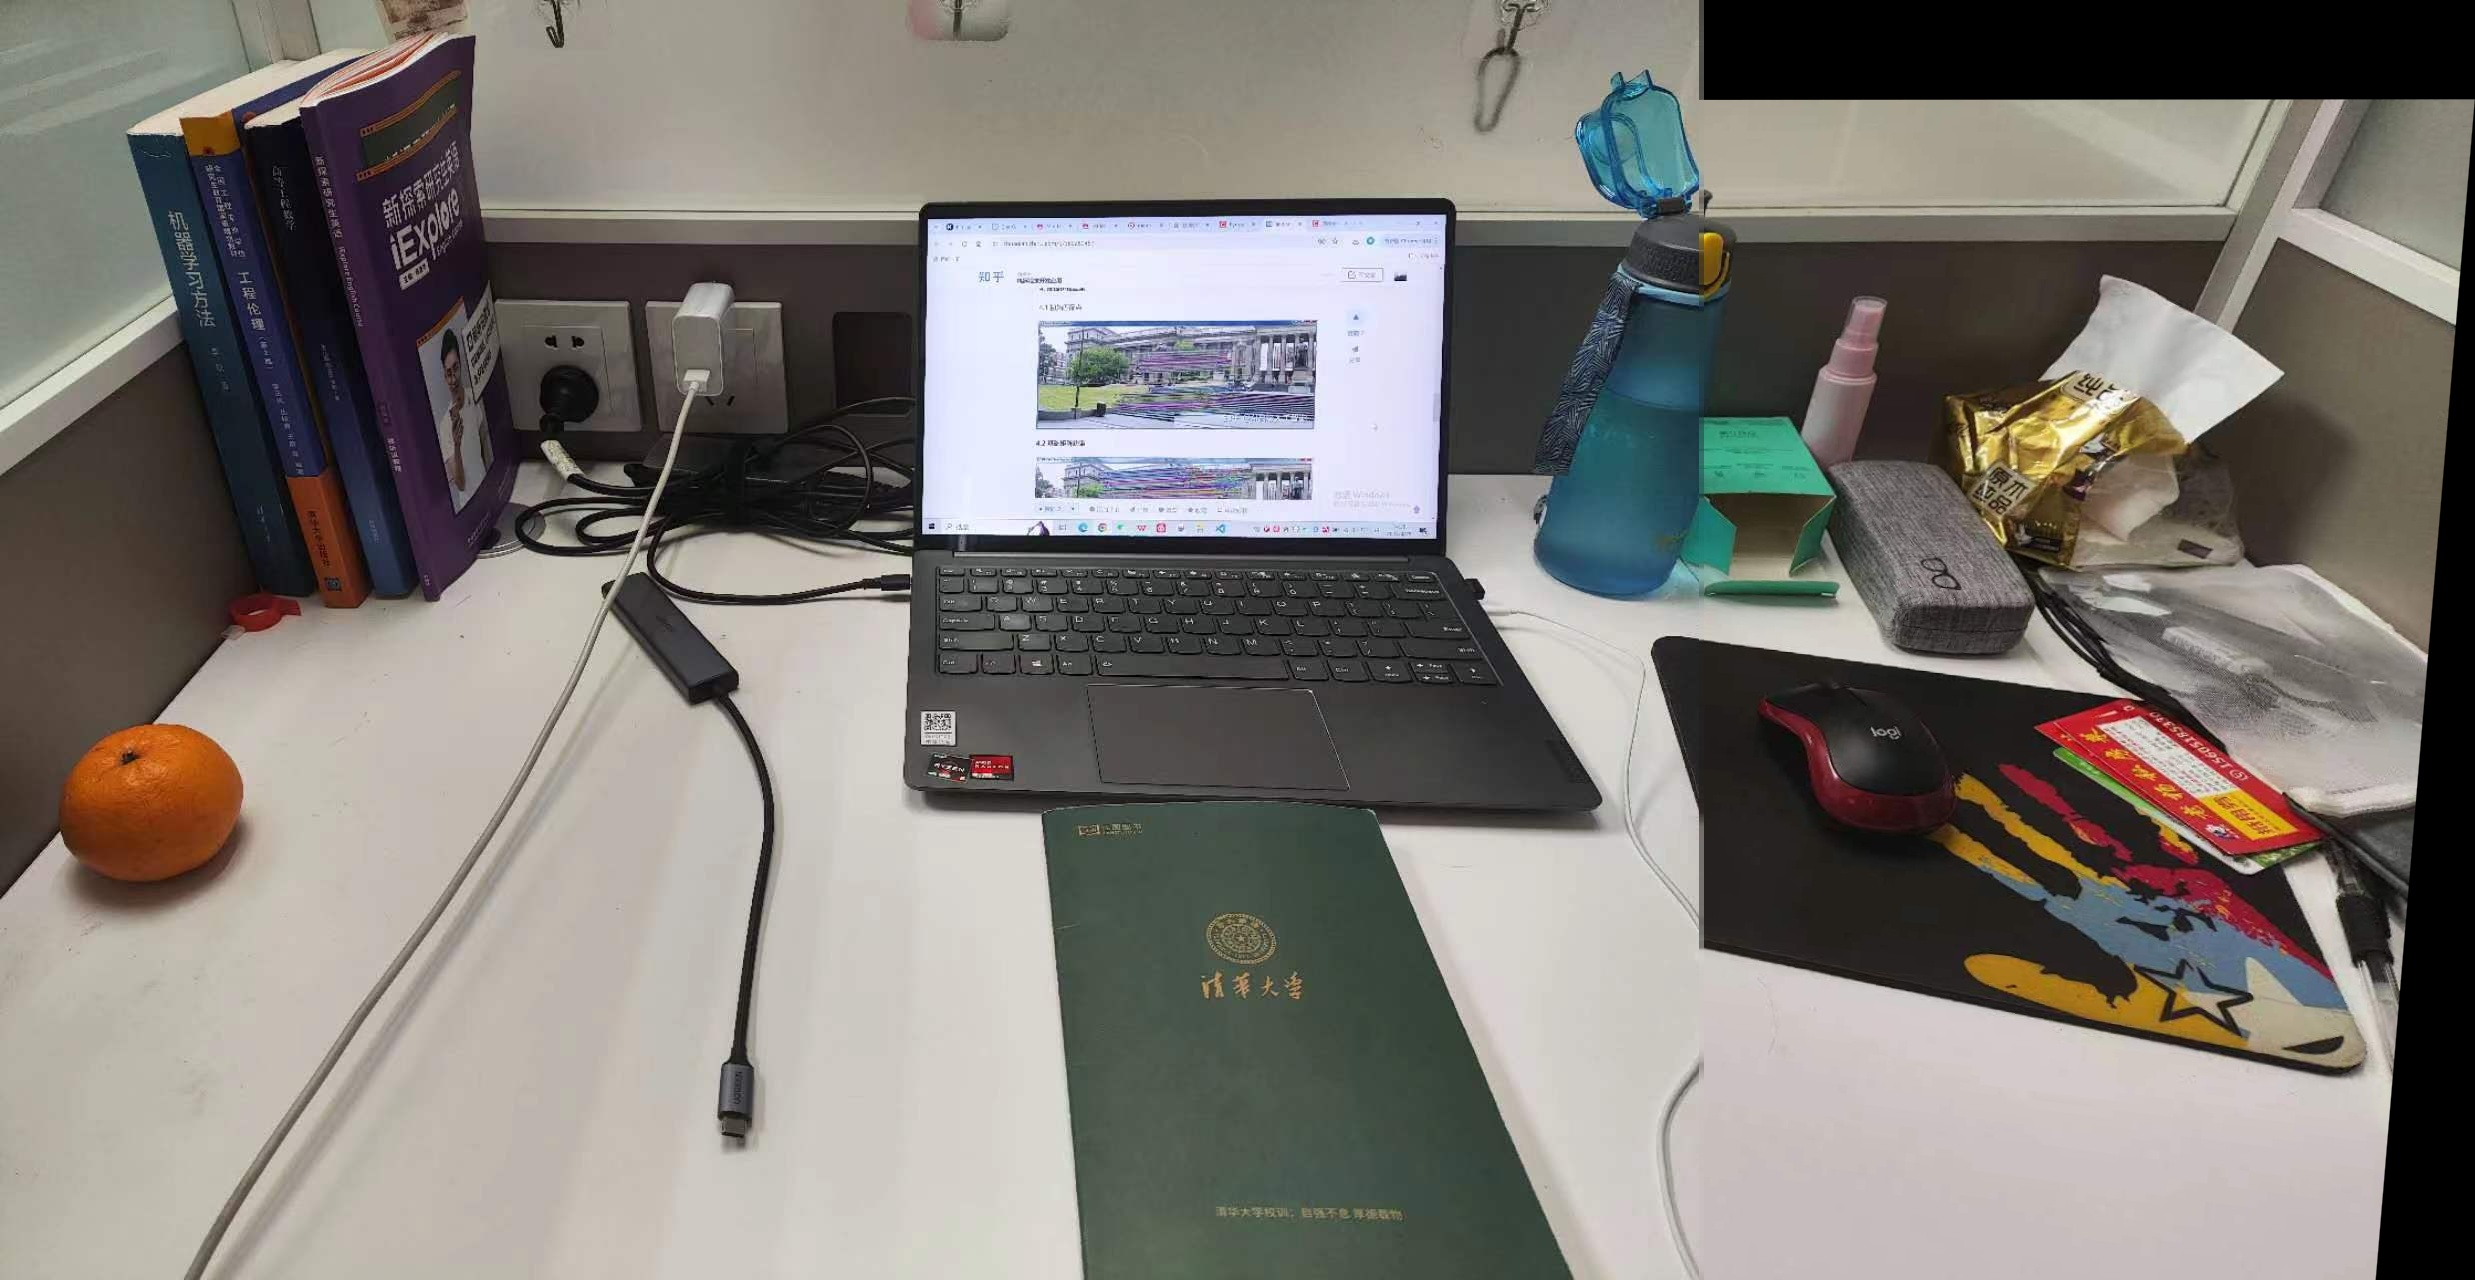

In [139]:
# 加载图像
image_path = 'stitched_image2.jpg'

# 显示图像
Image(filename=image_path)